In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

# Tensorflow uyarılarını engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Veri Analizi

In [59]:
df = pd.read_csv("international-airline-passengers.csv")
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [60]:
df.columns = ["Month","Passengers"]

In [61]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [62]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [63]:
df = df[:-1]

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [65]:
df.shape

(144, 2)

In [66]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [67]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [68]:
df["Month"] = pd.to_datetime(df["Month"])

In [69]:
df.head()

,Month,Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [71]:
df.Month.min()

Timestamp('1949-01-01 00:00:00')

In [72]:
df.Month.max()

Timestamp('1960-12-01 00:00:00')

In [73]:
df.index = df["Month"]

In [74]:
df.drop("Month", axis=1, inplace=True)

In [75]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [76]:
result_df = df.copy()

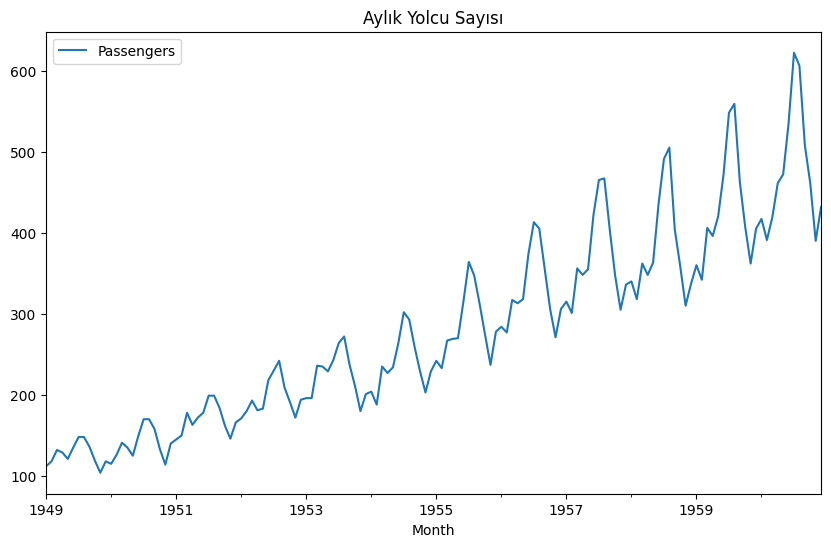

In [77]:
df.plot(figsize=(10, 6), title="Aylık Yolcu Sayısı");

## Verinin Hazırlanması

In [78]:
data = df["Passengers"].values

In [79]:
data = data.astype("float32")

In [80]:
data = data.reshape(-1, 1)

In [81]:
data.shape

(144, 1)

In [82]:
# eğitim ve test verilerini bölme
split = round(df.count().values[0] * 0.67)
train = data[:split]
test = data[split:]

In [83]:
train.shape, test.shape

((96, 1), (48, 1))

In [84]:
# Verileri modelin daha iyi performans göstermesi için dönüştürme
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaler_test = MinMaxScaler(feature_range=(0, 1))
train = scaler_train.fit_transform(train)
test = scaler_test.fit_transform(test)

In [85]:
# Verisetlerinin Hazırlanması
# y verisetlerini X verisetlerinin 1 adım ilerisi olacak şekilde ayarlıyoruz
X_train = train[:-1]
y_train = train.ravel()[1:]

X_test = test[:-1]
y_test = test.ravel()[1:]

In [86]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((95, 1), (95,), (47, 1), (47,))

In [87]:
# X verisetlerini 3 boyutlu, y verisetlerini 2 boyutlu hale getiriyoruz
X_train = X_train.reshape(-1, 1, 1)
X_test = X_test.reshape(-1, 1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [88]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((95, 1, 1), (95, 1), (47, 1, 1), (47, 1))

## RNN Modelleme

In [89]:
model = Sequential()
model.add(SimpleRNN(units=50, activation="relu", input_shape=(1, 1)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [90]:
model.summary() # Model Mimarisi

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
# Optimizasyon ve Değerlendirme Metriklerini Ayarlama
model.compile(loss="mean_squared_error", optimizer="adam")

In [92]:
callbacks = [EarlyStopping(monitor="val_loss", patience=3, mode="min", verbose=1),
            ModelCheckpoint(filepath="passengers.h5", monitor="val_accuracy", mode="max", 
                            verbose=1, save_best_only=True, save_weights_only=False)]

In [93]:
# Modelin Eğitilmesi
history = model.fit(
    x = X_train,
    y = y_train,
    epochs = 50,
    batch_size = 1,
    callbacks = callbacks,
    validation_data=(X_test, y_test),
    verbose = 1,
    shuffle = False
)

Epoch 1/50
95/95 [==============================] - 1s 3ms/step - loss: 0.0134 - val_loss: 0.0420
Epoch 2/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0209 - val_loss: 0.0246
Epoch 3/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0228
Epoch 4/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0214
Epoch 5/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0203
Epoch 6/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0212
Epoch 7/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0222
Epoch 8/50
95/95 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0208
Epoch 8: early stopping


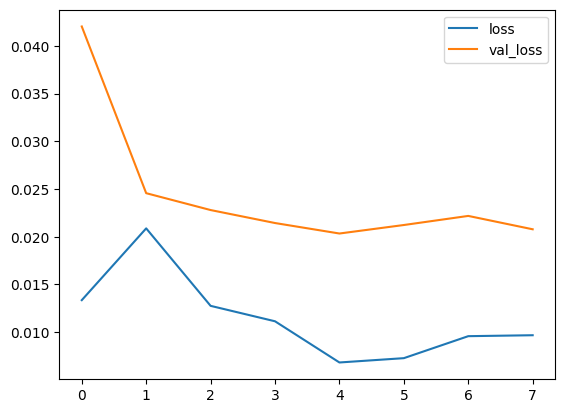

In [94]:
# Kayıp (maliyet) grafiği
loss = pd.DataFrame(history.history)
loss.plot();

In [95]:
pred = model.evaluate(X_test, y_test, batch_size=1)

47/47 [==============================] - 0s 739us/step - loss: 0.0208


In [96]:
print(f"Hata: %{pred*100:.2f}")

Hata: %2.08


In [97]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [98]:
# Dönüştürülen verileri eski hallerine getirme
train_pred = scaler_train.inverse_transform(train_pred)
test_pred = scaler_test.inverse_transform(test_pred)

In [99]:
# Dönüştürülen verileri eski hallerine getirme
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [100]:
# Hataların hesaplanması
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

In [101]:
print(f"Eğitim Hatası: {train_rmse:.2f}")
print(f"Test Hatası: {test_rmse:.2f}")

Eğitim Hatası: 23.03
Test Hatası: 46.27


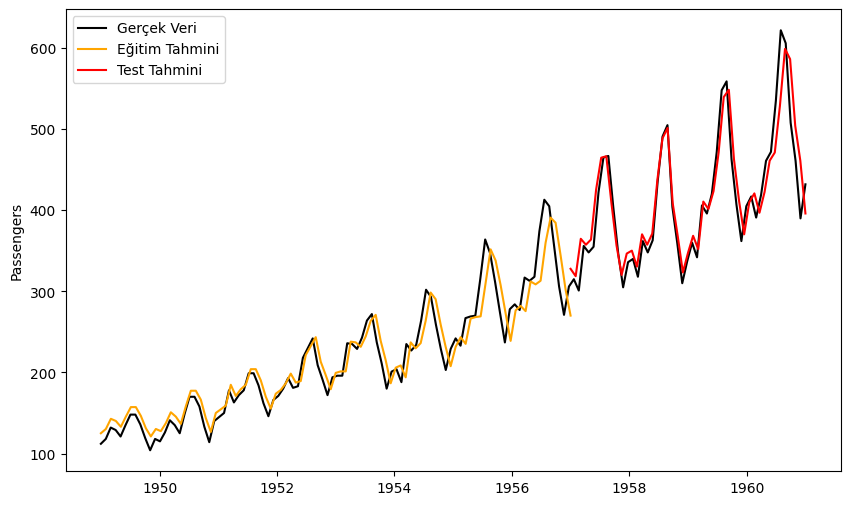

In [106]:
# Eğitim ve Test tahminlerinin gerçek veri ile karşılaştırılması
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=np.linspace(1949, 1961, 144), y="Passengers", color="black", label="Gerçek Veri")
sns.lineplot(x=np.linspace(1949, 1957, 95), y=train_pred.ravel(), color="orange", label="Eğitim Tahmini")
sns.lineplot(x=np.linspace(1957, 1961, 47), y=test_pred.ravel(), color="red", label="Test Tahmini");